In [1]:
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs 

# google earth engine specific 
import ee
import geemap
from google.auth import default
import certifi
import ssl

Prior to running the code below, I created an ee project. In this case, I initialized a free, non-commercial use project. This will need to be addressed as we move forward. The project was created in earth engine, and then the project ID and credentials were established by running the following line in terminal: 

`pip install google-auth google-auth-oauthlib google-auth-httplib2`
`earthengine authenticate`

This will open a browser window to login to the appropriate Google account. In the case you are already logged into another account, run the following code to reset

In [ ]:
import os
import shutil

ee_credentials_path = os.path.expanduser("~/.config/earthengine/credentials")

if os.path.exists(ee_credentials_path): 
    shutil.rmtree(os.path.dirname(ee_credentials_path)) 
    print("Existing Earth Engine credentials removed.") 
else: 
    print("No existing Earth Engine credentials found.")

Then if you are using a Mac, you may need to follow the instructions here to install your certificate: https://stackoverflow.com/questions/68275857/urllib-error-urlerror-urlopen-error-ssl-certificate-verify-failed-certifica

Following that, restart the kernel and continue

In [2]:
# Create a context using the certifi bundle
context = ssl.create_default_context(cafile=certifi.where())

# Run the following code to authenticate. You will be sent to retrieve an API token
ee.Authenticate()

# Initialize both earth engine and geemap
ee.Initialize(opt_url="https://earthengine.googleapis.com", project="dynamic-world-pipeline")
geemap.ee_initialize()


In [24]:
def get_boundaries(path):
    # given path to geojson file, return AOI polygon

    # load the file
    aoi_file = gpd.read_file(path)
    
    # convert the GeoPandas geometry to GeoJSON format
    aoi_geom = aoi_file.iloc[0].geometry.__geo_interface__
    
    ee_polygon = ee.Geometry(aoi_geom)
        
    return(ee_polygon)

def get_bbox(path):
    # given path to geojson file, return AOI

    # load the file
    aoi_file = gpd.read_file(path)

    # calculate the bounding box 
    bounds = aoi_file.total_bounds  # [minx, miny, maxx, maxy]
    
    # Create an ee.Geometry object from the bounding box
    aoi = ee.Geometry.Rectangle([bounds[0], bounds[1], bounds[2], bounds[3]])
    
    return(aoi)

def fetch_dynamic_world(aoi_path, date):
    """
    Function to acquire Dynamic World raster for a specific polygon and date.
    
    Input:
    aoi   : ee.Geometry.Polygon defining the area of interest
    date  : specific date to aim for (YYYY-MM-DD)
    
    Output:
    xr_ds : xarray Dataset containing the Dynamic World data for the nearest date +/- 10 days
    """
    # Define the date range around the specified date
    start_date = ee.Date(date).advance(-60, 'day')
    end_date = ee.Date(date).advance(60, 'day')
    
    # get aoi polygon
    aoi = get_bbox(aoi_path)
    
    # Load the Dynamic World image collection
    imcol = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
             .filterBounds(aoi)
             .filterDate(start_date, end_date)
             .select('label')
            )
    # make sure the projection matches our expected one from geojson
    #imcol = imcol.map(lambda img: img.reproject(crs='EPSG:4326', scale=10))
        
    # function to identify nearest date
    #def nearest(items, pivot):
        #return min(items, key=lambda x: abs(x - pivot))

    # Get the list of dates in the collection
    #dates = imcol.aggregate_array('system:time_start').getInfo()
    #dates = [np.datetime64(ee.Date(date).format('YYYY-MM-dd').getInfo()) for date in dates]
    #print(f'dates: {dates}')

    #nearest_date = nearest(dates, np.datetime64(date))
    #print(f'nearest date: {nearest_date}')

    #one_day_dw = imcol.filterDate(
            #str(nearest_date), str(nearest_date + np.timedelta64(1, 'D')))
    
    #print(f'one day dw: {one_day_dw}')

    # Reduce to the most probable land cover type
    most_probable = imcol.reduce(ee.Reducer.mode())

    #dwComposite = classification.reduce(ee.Reducer.mode())  
    
    # Convert the image to an xarray.Dataset
    #xr_ds = geemap.ee_to_xarray(most_probable)

    # Export the image as GeoTIFF
    geemap.ee_export_image(most_probable, filename='dynamic_world_aoi.tif', scale=10, region=aoi)
    
    #return(one_day_dw, most_probable.clip(aoi))
    return 'dynamic_world_aoi.tif'

In [25]:
# set date
# note that DW does not have regular date intervals, so we just select the nearest date
date = '2021-06-02'

geojson_path = "/Users/snix/Documents/2024/Cecil/AOISimplification/AOIs/reesets/st_aidans_boundary_reserve/aoi.geojson"

# call data
dynamic_world_tif = fetch_dynamic_world(geojson_path, date)

Generating URL ...
Please wait ...
Data downloaded to /Users/snix/Documents/2024/Cecil/dynamic-world-pipeline/dynamic_world_aoi.tif


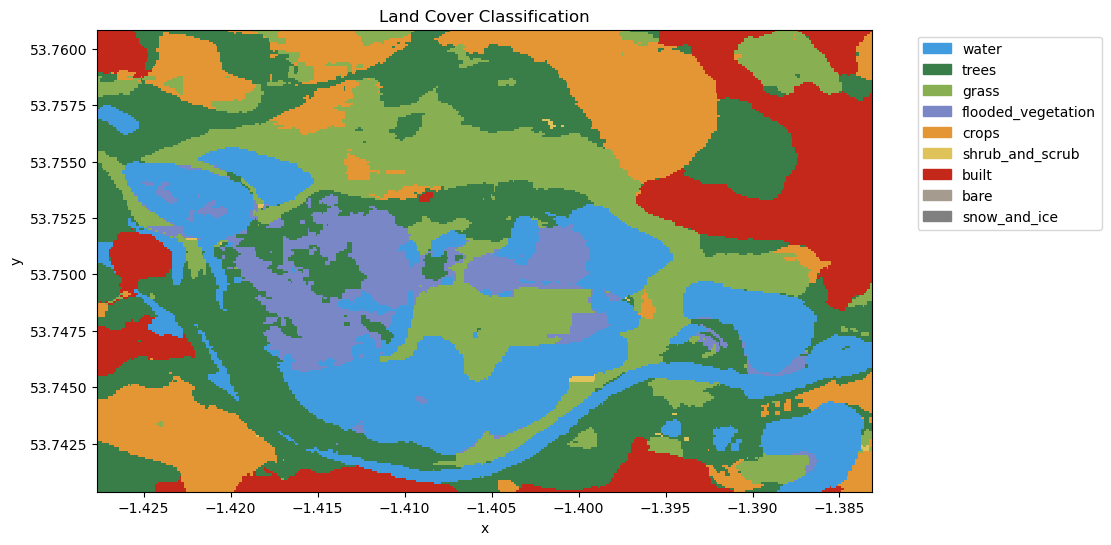

In [27]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the color palette, labels, and corresponding values
colors = ['#419bdf', '#397d49', '#88b053', '#7a87c6', '#e49635', '#dfc35a', '#c4281b', '#a59b8f', '#808080']  # Gray for snow_and_ice
labels = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
values = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Raster values that correspond to each land cover type

# Create a colormap and a normalization based on the values
cmap = ListedColormap(colors)
norm = BoundaryNorm(values + [max(values) + 1], cmap.N)  # Ensures correct mapping of values to colors

# Open the GeoTIFF using rioxarray
classification = rxr.open_rasterio(dynamic_world_tif)

# Plot the classification raster
plt.figure(figsize=(10, 6))
img = classification.plot(cmap=cmap, norm=norm, add_colorbar=False)

# Create a custom legend
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.title('Land Cover Classification')
plt.show()


In [ ]:
xrs

In [ ]:
# Convert dataset to xarray and rename x and  y dims.
xrs = geemap.ee_to_xarray(xr_ds)
xrs = xrs.rename({'lat': 'y', 'lon': 'x'})
xrs

In [ ]:
# Load the AOI file. 
aoi_file = gpd.read_file(geojson_path)

# Calculate the bounding box. 
bounds = aoi_file.total_bounds  # [minx, miny, maxx, maxy]

# Clip the dataset to the bounds of the AOI.
clipped = xrs.rio.clip(aoi_file.geometry.apply(mapping), aoi_file.crs)

In [ ]:
xrs